In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset
import numpy as np
import random

import time
import os

Creazione del grafo con l'algoritmo di Barabasi-Albert

In [2]:
N = 50
M = 3
G = nx.barabasi_albert_graph(N, M)

Rappresentazione del grafico

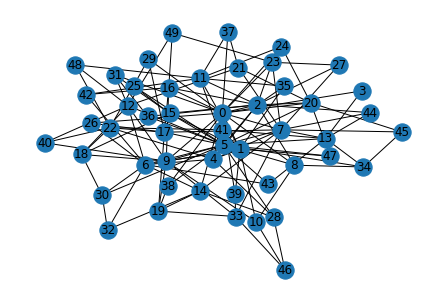

In [3]:
nx.draw(G, with_labels=True)    
plt.show()

Distribuzione della connettività dei nodi

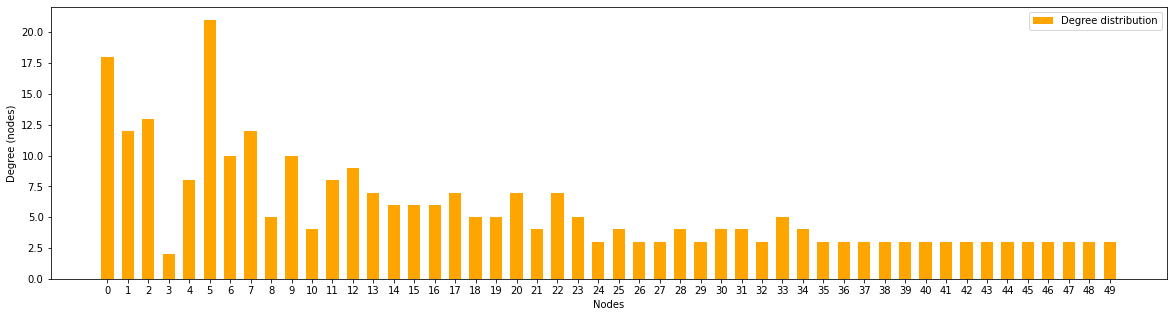

In [4]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.4*N, 5))

ax.bar(G.nodes, [d for n,d in G.degree], width=0.6, 
          align='center', color='orange', label='Degree distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Degree (nodes)")
ax.set_xticks(np.arange(0, N, 1))
# ax[i].grid(True)

plt.show()

Estrazione della matrice di adiacenza A

In [5]:
adjacency = list(G.adjacency())
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)] 
    for c in b : 
        A[a][c] = 1

Estrazione della matrice di stocastica P e calcolo dei suoi autovalori e autovettori

In [6]:
P = []
for a, b in adjacency :
    P += [[0]*len(adjacency)]
    for c in b: 
        P[a][c] = 1./G.degree[a]

In [7]:
matrixP = np.array(P)
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)
pS = autovettoriP[0]
if pS[0] < 0:
    pS = -pS
#np.dot(np.transpose(matrix),autovettori[0])

In [8]:
autovaloriP

array([ 1.        , -0.69683381,  0.64275019,  0.6180118 , -0.63472866,
       -0.60759786, -0.59953762, -0.55582673, -0.54709229, -0.51202006,
        0.57590404, -0.47709559, -0.45323052,  0.54741465,  0.53211012,
       -0.42688249, -0.39775707,  0.47719372,  0.4620188 ,  0.44608221,
       -0.35917378, -0.34065471, -0.32273022, -0.29242751, -0.2626974 ,
        0.3901773 ,  0.37223524, -0.20041945,  0.32665353,  0.29875005,
       -0.17105947, -0.14685788, -0.12730303, -0.10523598, -0.10055376,
        0.27425678,  0.24971246, -0.0608145 ,  0.21290089,  0.21712051,
       -0.026225  , -0.01024706,  0.01805538,  0.0330516 ,  0.18214011,
        0.15881464,  0.12696098,  0.11074173,  0.07566019,  0.08628553])

Definizione della matrice laplaciana L e calcolo dei suoi autovettori e autovalori

In [9]:
matrixL = np.identity(N) - matrixP

In [10]:
autovaloriL, autovettoriL = np.linalg.eig(np.transpose(matrixL))
autovettoriL = np.transpose(autovettoriL)
pS_L = autovettoriL[0]
if pS_L[0] < 0:
    pS_L = -pS_L

In [11]:
autovaloriL

array([1.45102498e-16, 1.69683381e+00, 3.57249806e-01, 3.81988200e-01,
       4.24095957e-01, 1.63472866e+00, 1.60759786e+00, 1.59953762e+00,
       1.55582673e+00, 1.54709229e+00, 4.52585354e-01, 4.67889878e-01,
       1.51202006e+00, 1.47709559e+00, 1.45323052e+00, 1.42688249e+00,
       1.39775707e+00, 5.22806276e-01, 5.37981197e-01, 5.53917786e-01,
       1.35917378e+00, 1.34065471e+00, 1.32273022e+00, 1.29242751e+00,
       1.26269740e+00, 6.09822702e-01, 6.27764758e-01, 1.20041945e+00,
       6.73346475e-01, 1.17105947e+00, 1.14685788e+00, 1.12730303e+00,
       1.10523598e+00, 1.10055376e+00, 7.01249955e-01, 7.25743225e-01,
       7.50287539e-01, 1.06081450e+00, 7.87099105e-01, 7.82879494e-01,
       8.17859893e-01, 1.02622500e+00, 1.01024706e+00, 9.81944625e-01,
       9.66948404e-01, 8.41185360e-01, 8.73039018e-01, 8.89258268e-01,
       9.24339809e-01, 9.13714469e-01])

La distribuzione stazionaria e il valore di Fiedler estratto dalle due matrici L e P coincidono fino alla 13-esima cifra decimale

In [12]:
i = 13
np.round(pS, i) == np.round(pS_L, i)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [13]:
np.round(1-max(autovaloriP[1:]), i) == np.round(min(autovaloriL[1:]), i)

True

Definizione del valore valore di Fiedler e della distribuzione stazionaria approssimate

In [14]:
FiedlerValue = round(min(autovaloriL[1:]), i)

In [15]:
pS = np.round(pS, i)

Assegnazione degli individui ai nodi per l'evoluzione della dinamica. L'assegnazione degli individui è fatta secondo una distribuzione uniforme.

In [16]:
walker_per_node = 20

In [17]:
seed = np.random.RandomState()
def dynamic_evolution(G, history = []):
    evolution = [0] * len(G.nodes)
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neighbours = list(G[n])
            new_node = _random_subset(neighbours, 1, seed).pop()
            evolution[new_node] += 1
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[n]
    history += [evolution]

In [18]:
history = [[], [], []]
for h in range(len(history)):
    history[h] = [[walker_per_node] * len(G.nodes)]

# history[0] = [[walker_per_node] * len(G.nodes)]
# history[1] = [[walker_per_node] * len(G.nodes)]
# history[2] = [[walker_per_node] * len(G.nodes)]
time_steps = int(5e2)

In [19]:
t0 = time.time()

for h in range(len(history)):
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
        dynamic_evolution(G, history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 15.34761118888855 seconds


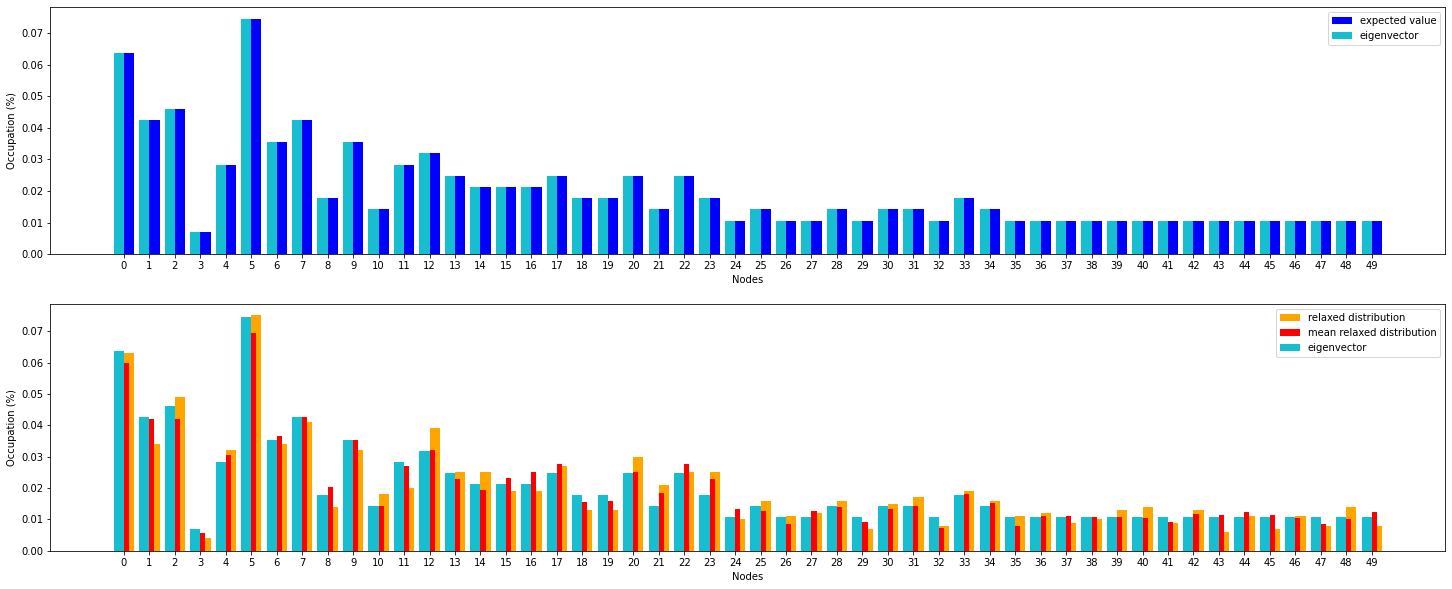

In [20]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(0.5*N, 10))

pSNorm = [d for n, d in G.degree()]
pSNorm = [h/sum(pSNorm) for h in pSNorm]

hMean = [[(h1+h2+h3)/(walker_per_node*N*3) 
         for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] for i in range(len(history[0]))]

ax[0].bar(G.nodes, [h/sum(pSNorm) for h in pSNorm], width=0.4, align='edge', color='blue', label="expected value")
ax[0].bar(G.nodes, [h/sum(pS) for h in pS], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

ax[1].bar(G.nodes, [h/sum(history[0][-1]) for h in history[0][-1]], width=0.4, 
          align='edge', color='orange', label='relaxed distribution')
ax[1].bar(G.nodes, hMean[-1], width=0.2, align='edge', color='red', label='mean relaxed distribution')
ax[1].bar(G.nodes, [h/sum(pS) for h in pS], width=-0.4, align='edge', color='tab:cyan', label="eigenvector")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Nodes")
    ax[i].set_ylabel("Occupation (%)")
    ax[i].set_xticks(np.arange(0, N, 1))
#     ax[i].grid(True)


plt.show()

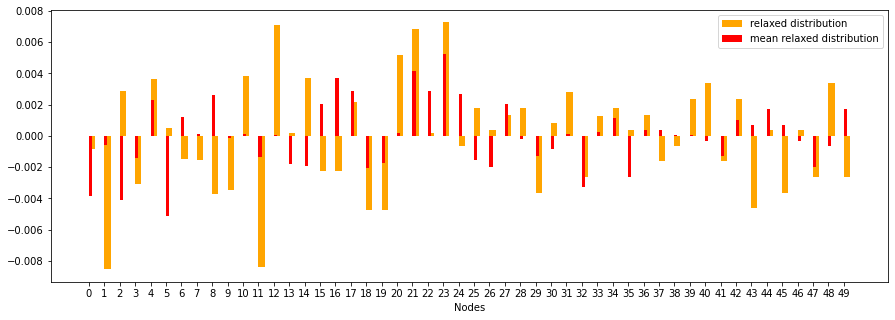

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.3*N, 5))

ax.bar(G.nodes, [h/sum(history[0][-1]) - k for h, k in zip(history[0][-1], pSNorm)], width=0.4, 
          align='edge', color='orange', label='relaxed distribution')
ax.bar(G.nodes, [(h1+h2+h3)/(sum(history[0][-1]) + sum(history[1][-1]) + sum(history[2][-1])) - k
                    for h1, h2, h3, k in zip(history[0][-1], history[1][-1], history[2][-1], pSNorm)],
          width=0.2, align='edge', color='red', label='mean relaxed distribution')

ax.legend()
ax.set_xlabel("Nodes")
# ax.set_ylabel("Occupation (%)")
ax.set_xticks(np.arange(0, N, 1))
# ax[i].grid(True)

plt.show()

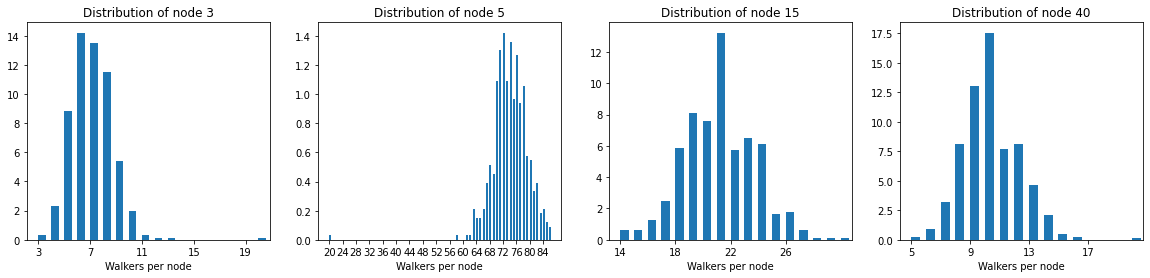

In [22]:
nodes = [3, 5, 15, 40]
p_node = []

fig, ax = plt.subplots(nrows = 1, ncols = len(nodes), figsize=(5*len(nodes), 4))

histo = hMean

for i in range(len(nodes)):
    p_node += [[int(h[nodes[i]]*walker_per_node*N) for h in histo]]
    ax[i].hist(p_node[i], bins = walker_per_node*N, density = True, align='left', width=0.6)
    ax[i].set_title(f"Distribution of node {nodes[i]}")
    ax[i].set_xlabel("Walkers per node")
    ax[i].set_xticks(np.arange(min(p_node[i]), max(p_node[i]), 4))

plt.show()

In [23]:
for i in range(len(nodes)):
    print("DIstribution for node", nodes[i], ":")
    print(sum(p_node[i])/time_steps)
    print(pSNorm[nodes[i]]*N*walker_per_node)
    print()

DIstribution for node 3 :
6.882
7.092198581560284

DIstribution for node 5 :
74.034
74.46808510638297

DIstribution for node 15 :
20.934
21.27659574468085

DIstribution for node 40 :
10.142
10.638297872340425



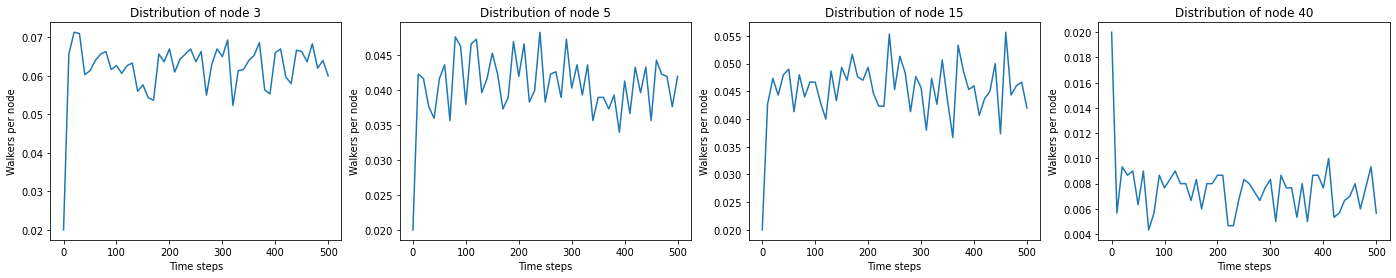

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = len(nodes), figsize=(6*len(nodes), 4))

time_range = hMean
index = np.arange(0, len(time_range), 10)

for i in range(len(nodes)):
    ax[i].plot(index, [time_range[ind][i] for ind in index])
    ax[i].set_title(f"Distribution of node {nodes[i]}")
    ax[i].set_ylabel("Walkers per node")
    ax[i].set_xlabel("Time steps")

plt.show()

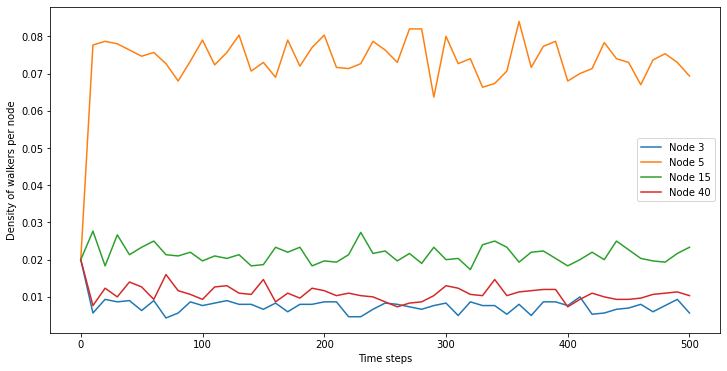

In [26]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12,1.5*len(nodes)))

for i in nodes: #list(G.nodes)[0:3]:
    plt.plot(index, [time_range[ind][i] for ind in index], label = f"Node {i}")
    [time_range[ind][i] for ind in index]
#     plt.plot(index, [time_range[ind][i] for ind in index])
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()

#### Note:

* aggiungere fit su distribuzioni di walkers

* sistema grafica concentrazioni di individui su ogni nodo

* fare grafico per fittare valore di Fiedler